In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess
import src.data_raw as data_raw
from src.util.run_util import create_timedelta_and_plot

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


# TODO:

- BUG: why is len(trades) in render much lower than timesteps? In price plot, there are steps without trade but where the price changes. Suspiocus. Reprocuce with config training 1500, config predict 500, and nb predict 450. Merge trades with the df, and see where thare are none, might provide clue. COuld also print current_step in _take_action/_get_trade functions.
- Explore self.reward_range = (0, 2147483647)
- Double check all available reward functions and classes are fast
- Consider ffill nan handling for TI:s (and likely dropping the filled data after)
- Test different setting of exploration
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt. Some Medium articles uses Sharpe values, investigate.
- Discover new promising reward functions
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- Set good period for ti features
- Test other TI packages for better efficiency
- Revisit technical features
- Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Hyperparameter search
- Optimize to save some time every iteration
- Explore different gamma (Discount factor)
- Correct for displaced index due to specified TI NaNs
- Checkout frame stacking as a poor man's lstm (unlikely that it's useful, since we're dealing with time series)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better. See for exampåle  discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks
- Add dynamic data download and preparation by downloading all transactions -> render OHLC in multiple time granularities
- Add full support for multiprocessing
- Suppress tensorflow warnings
- Substantial time optimizations to avoid growing time per iteration of training
- Substantial memory savings from only saving data we need during training
- Added flag to refresh data
- No data copy when building Docker cotainer -- MUCH faster Docker builds
- Properly save model, normalization statistics, and some useful meta data

# Run

In [2]:
record_time = False
force_refresh = False

In [3]:
%%time
data_raw.download_and_process(force_refresh=force_refresh)
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df)
config.n_cpu=8
env = run.setup_env(df=df, record_time=record_time)

Processed data avilable locally, no downloading and raw data processing needed.
LOAD: Loading data with 23615326 samples
PREPROCESS: Dropping 0 NaNs out of 23615326 samples (0.0%) from input file
PREPROCESS: Dropping unused data, 23615326 -> 2010 samples
PREPROCESS: Adding technical features...
Done.
Performing NaN/inf check on data...
Done.
Setting up environment using 8 cores...
Resetting to timesteps: start 23613450 (2020-09-28 01:22:10), end 23614825 (2020-09-28 08:28:35)
2020-09-28 01:22:10
2020-09-28 01:22:13
2020-09-28 01:22:17
2020-09-28 01:22:35
2020-09-28 01:23:10
2020-09-28 01:23:25
2020-09-28 01:23:36
2020-09-28 01:24:02
2020-09-28 01:24:33
2020-09-28 01:24:52
2020-09-28 01:25:06
2020-09-28 01:25:26
Done.
CPU times: user 3.05 s, sys: 2.58 s, total: 5.63 s
Wall time: 28.6 s


In [4]:
%%time
past = datetime.now()
model = run.train(env=env, logging=True)
#print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/config.train_predict.train_timesteps}')
#print(f'Avg time per total timestep: {(datetime.now()-past).total_seconds()/config.train_predict.train_timesteps/config.n_cpu}')
if record_time:
    create_timedelta_and_plot(model=model)

RUN: Training for 1500 serial timesteps and 12000 total timesteps...
RUN: Saving files to ./data/models/24/
Done.
CPU times: user 5.35 s, sys: 1.74 s, total: 7.09 s
Wall time: 9.66 s


RUN: Loading files from ./data/models/24/
RUN: Model connected with env
RUN: Predicting for 450 timesteps
Resetting to timesteps: start 23614835 (2020-09-28 08:32:37), end 23615325 (2020-09-28 10:16:00)
2020-09-28 08:32:37
2020-09-28 08:34:04
2020-09-28 08:34:06
2020-09-28 08:34:18
2020-09-28 08:34:36
2020-09-28 08:35:03
2020-09-28 08:35:07
2020-09-28 08:35:40
2020-09-28 08:35:46
2020-09-28 08:35:50
2020-09-28 08:36:06
2020-09-28 08:36:12
2020-09-28 08:36:18
2020-09-28 08:36:36
2020-09-28 08:37:21
2020-09-28 08:38:06
2020-09-28 08:38:07
2020-09-28 08:38:18
2020-09-28 08:38:36
2020-09-28 08:38:41
2020-09-28 08:38:59
2020-09-28 08:39:00
2020-09-28 08:39:22
2020-09-28 08:40:04
2020-09-28 08:40:06
2020-09-28 08:40:07
2020-09-28 08:40:38
2020-09-28 08:40:49
2020-09-28 08:41:12
2020-09-28 08:41:14
2020-09-28 08:41:18
2020-09-28 08:42:06
2020-09-28 08:42:14
2020-09-28 08:42:19
2020-09-28 08:42:38
2020-09-28 08:43:00
2020-09-28 08:43:03
2020-09-28 08:43:16
2020-09-28 08:43:18
2020-09-28 08:43:

2020-09-28 10:09:14
2020-09-28 10:09:16
2020-09-28 10:09:21
2020-09-28 10:09:26
2020-09-28 10:09:30
2020-09-28 10:09:43
2020-09-28 10:09:44
2020-09-28 10:09:45
2020-09-28 10:09:57
2020-09-28 10:09:58
2020-09-28 10:10:13
2020-09-28 10:10:18
2020-09-28 10:10:24
2020-09-28 10:10:25
2020-09-28 10:10:26
2020-09-28 10:10:30
2020-09-28 10:10:35
2020-09-28 10:10:50
Rendering TradingChartStatic for index steps 23614835 (2020-09-28 08:32:37) through 23615285 (2020-09-28 10:10:50)
X1: 245


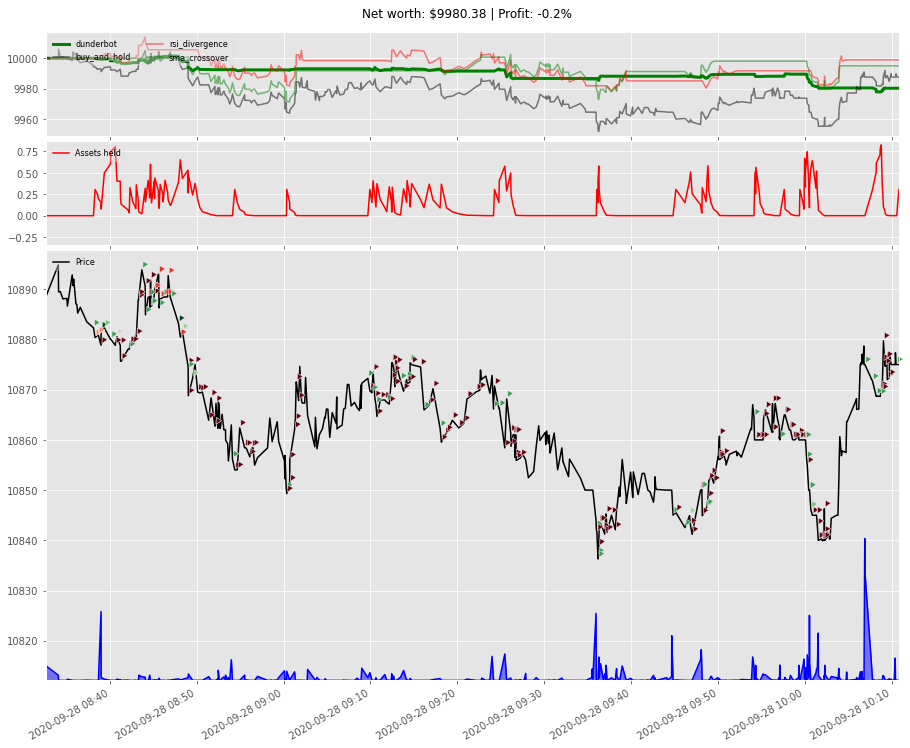

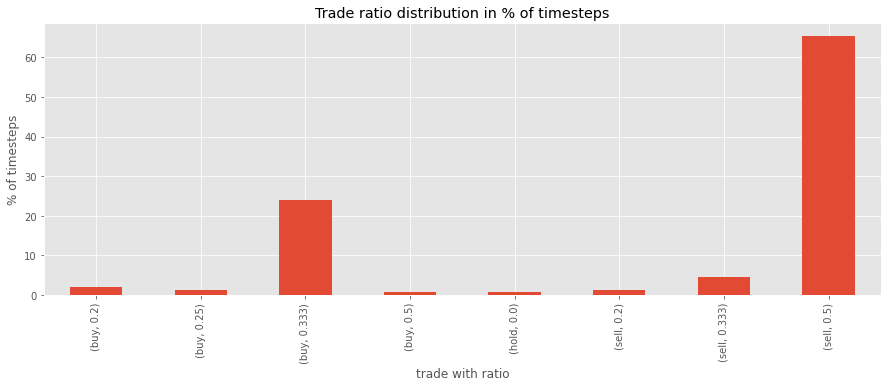

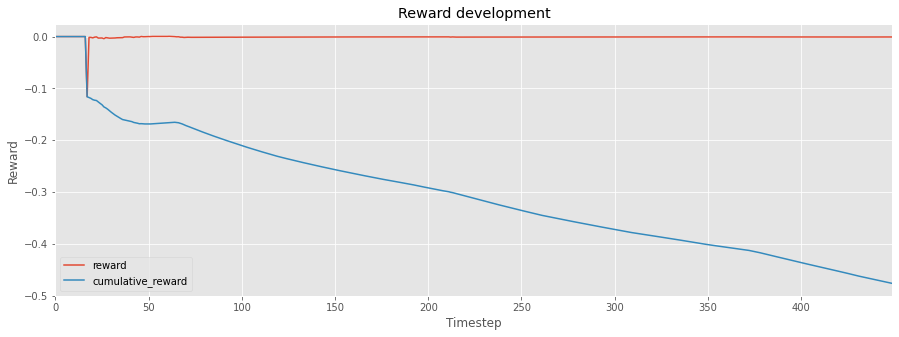

CPU times: user 8.75 s, sys: 863 ms, total: 9.61 s
Wall time: 8.72 s


In [4]:
%%time
run.predict(df=df, timesteps=450, rendermode='plots')

In [9]:
df

,Timestamp,Open,High,Low,Close,VolumeBTC,Symbol,ti_bb_hind,ti_bb_lind,ti_bb_wband,ti_ii_senkou_a,ti_ii_senkou_b,ti_ii_kijun_sen,ti_rsi,ti_macd_hist,ti_adx,ti_adx_neg,ti_adx_pos,ti_cmf
23613316,2020-09-28 00:59:54,10880.00,10885.00,10880.00,10885.00,4.945935,BTCUSD,0.0,0.0,NaN,NaN,10882.50,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
23613317,2020-09-28 00:59:55,10885.00,10885.00,10885.00,10885.00,0.688792,BTCUSD,0.0,0.0,NaN,NaN,10882.50,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
23613318,2020-09-28 00:59:56,10885.00,10885.00,10885.00,10885.00,0.027534,BTCUSD,0.0,0.0,NaN,NaN,10882.50,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
23613319,2020-09-28 00:59:57,10885.00,10885.00,10885.00,10885.00,0.202297,BTCUSD,0.0,0.0,NaN,NaN,10882.50,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
23613320,2020-09-28 00:59:59,10885.00,10885.00,10885.00,10885.00,0.137670,BTCUSD,0.0,0.0,NaN,NaN,10882.50,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23615321,2020-09-28 10:14:57,10876.16,10876.16,10875.12,10875.12,0.010088,BTCUSD,0.0,0.0,0.068137,10879.04,10877.55,10879.04,46.793894,-0.322891,32.520021,36.214151,46.840605,0.565185
23615322,2020-09-28 10:15:17,10881.87,10881.88,10881.87,10881.88,0.217167,BTCUSD,1.0,0.0,0.077721,10879.04,10877.55,10879.04,60.635998,0.058975,32.749644,26.817792,56.641895,0.577860
23615323,2020-09-28 10:15:27,10877.50,10877.50,10877.50,10877.50,0.021824,BTCUSD,0.0,0.0,0.075898,10879.04,10877.55,10879.04,51.319818,0.010194,31.237827,38.001206,47.959017,0.579076
23615324,2020-09-28 10:15:35,10877.49,10877.49,10877.49,10877.49,0.003000,BTCUSD,0.0,0.0,0.073777,10878.74,10877.76,10879.04,51.300439,-0.027090,29.830504,38.024565,47.940948,0.580631


In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 23615285,
 'net_worths': [10000,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  9999.41,
  9999.52,
  9999.53,
  9999.21,
  9999.44,
  9999.65,
  9998.28,
  9998.28,
  9998.29,
  9997.31,
  9998.01,
  9997.3,
  9996.67,
  9996.66,
  9996.83,
  9996.83,
  9997.14,
  9997.14,
  9997.27,
  9997.27,
  9998.58,
  9998.58,
  9998.6,
  9998.73,
  9997.69,
  9996.77,
  9998.21,
  9998.22,
  9997.34,
  10000.6,
  9999.03,
  9999.03,
  9999.84,
  10000.07,
  10000.07,
  10001.01,
  10001.0,
  10001.01,
  10000.43,
  10001.07,
  10001.15,
  10001.15,
  10001.17,
  10001.18,
  10001.96,
  10001.44,
  10001.39,
  9999.51,
  9997.7,
  9998.21,
  9994.57,
  9994.37,
  9991.85,
  9992.69,
  9993.72,
  9992.67,
  9992.66,
  9992.67,
  9992.53,
  9992.59,
  9992.55,
  9992.55,
  9992.56,
  9992.56,
  9992.56,
  9992.56,
  9992.56,
  9992.56,
  999

In [7]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])

In [8]:
x['trades']

[{'step': 23614851,
  'amount': 0.30630751,
  'total': 3333.33,
  'type': 'buy',
  'action_amount': 0.3333333333333333},
 {'step': 23614852,
  'amount': 0.0612615,
  'total': 666.55,
  'type': 'sell',
  'action_amount': 0.2},
 {'step': 23614853,
  'amount': 0.0490092,
  'total': 533.26,
  'type': 'sell',
  'action_amount': 0.2},
 {'step': 23614854,
  'amount': 0.03920736,
  'total': 426.61,
  'type': 'sell',
  'action_amount': 0.2},
 {'step': 23614855,
  'amount': 0.07841472,
  'total': 853.06,
  'type': 'sell',
  'action_amount': 0.5},
 {'step': 23614856,
  'amount': 0.42024678,
  'total': 4573.08,
  'type': 'buy',
  'action_amount': 0.5},
 {'step': 23614857,
  'amount': 0.10505752,
  'total': 1143.27,
  'type': 'buy',
  'action_amount': 0.25},
 {'step': 23614858,
  'amount': 0.06304768,
  'total': 685.96,
  'type': 'buy',
  'action_amount': 0.2},
 {'step': 23614859,
  'amount': 0.08406357,
  'total': 914.61,
  'type': 'buy',
  'action_amount': 0.3333333333333333},
 {'step': 23614860,